In [1]:
import sys
sys.path.append('./src/')
import os
os.chdir("../")

In [2]:
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import encode_labels


In [3]:
config_file = "config.json"
with open(config_file, 'r') as f:
    config = json.load(f)

In [4]:
model_path = "./models/model_bst.pkl"
model, class_names = joblib.load(model_path)
class_map= {class_names[i]:i for i in range(len(class_names))}
class_map


{'constant': 0, 'multi': 1, 'normal': 2, 'rapid': 3}

In [5]:
test_data_path = config['processed_test_data_path']
df_test = pd.read_csv(test_data_path)
y0_test = df_test['cluster']
X_test = df_test.drop(columns={'cluster','well'})
y_test, _ = encode_labels(y0_test)
y_test_pred = model.predict(X_test)
y_test_pred

array([2, 3, 0, 3, 2, 0, 0, 0, 1, 0, 0, 3, 2, 3, 0, 1, 0, 2, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 2, 0, 0, 1, 3, 3, 1, 1, 2, 0, 3, 0, 1, 1, 2,
       1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 3, 2,
       0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 3, 1, 3, 0, 2,
       2])

In [6]:
norm_conf_mx = confusion_matrix(y_test, y_test_pred,normalize='true')
norm_conf_mx

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

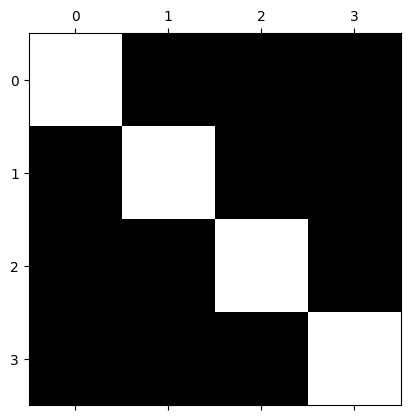

In [7]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

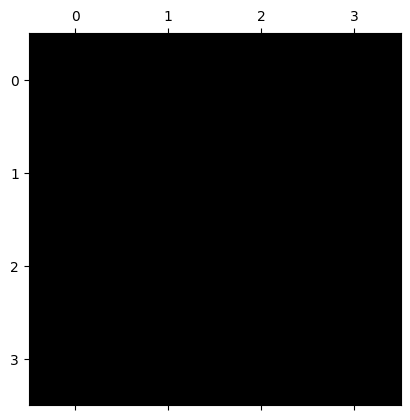

In [8]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* The column of class 2 is bright, which tells you that many samples get misclassified as 2s. 
* 
* sample 2 is confused with sample 0 
* Sample 3 is all over the place, it gets confused with 0, 1, and mostly with  2.
* never, anyclass is confused as sample 3

**How can we reduce the false 2s?**

In [9]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 0")
)


,well,y,p
2,well_120,0,0
5,well_126,0,0
6,well_128,0,0
7,well_132,0,0
9,well_142,0,0
10,well_143,0,0
14,well_161,0,0
16,well_190,0,0
18,well_2,0,0
20,well_250,0,0


In [10]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 2")
)


,well,y,p


In [11]:
well_id = 'well_120'
df_well = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
 .groupby('well')
 .get_group(well_id)
 .sort_values(['date'])
 #.filter(['date','value'])
 .set_index('date')
)
df_well.head()

,well,value,cluster
date,,,
1977-03-01,well_120,1.771429,constant
1977-04-01,well_120,1.843750,constant
1977-05-01,well_120,0.481928,constant
1977-06-01,well_120,0.000000,constant
1977-07-01,well_120,0.717949,constant


In [12]:
well_cluster = df_well['cluster'].iloc[0]
well_cluster

'constant'

In [13]:
df_well_Y = df_well[["value"]].resample('Y').mean()
df_well_Y.head()

/var/folders/1n/2j_57fhs4hd7p8xz6gg76p7w0000gn/T/ipykernel_16022/3203870136.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_well_Y = df_well[["value"]].resample('Y').mean()


,value
date,
1977-12-31,0.814464
1978-12-31,0.848213
1979-12-31,1.002060
1980-12-31,2.366487
1981-12-31,1.911037


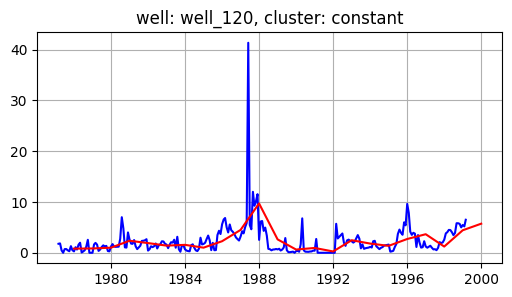

In [14]:
plt.figure(figsize=(6,3))
plt.plot(df_well.index, df_well.value,color='blue')
plt.title(f'well: {well_id}, cluster: {well_cluster}')
plt.grid(True)
plt.plot(df_well_Y.index, df_well_Y.value,color='red')
plt.show()

In [15]:
wells = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p==0")
 .sample(25)
 .well
 .to_list()
)
len(wells)


25

In [24]:
pivot_df = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            .query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            .sample(25)
)
pivot_df

date,1977-01-01,1977-02-01,1977-03-01,1977-04-01,1977-05-01,1977-06-01,1977-07-01,1977-08-01,1977-09-01,1977-10-01,...,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01
well,,,,,,,,,,,,,,,,,,,,,
well_514,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_47,NaN,NaN,9.041401,5.131970,5.959488,5.313525,5.530364,6.042373,5.993671,5.806667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.028169,32.000000,25.743243,22.554217,20.189873,16.925000,20.150685,24.743243,25.160000,24.369863
well_275,36.545259,37.129697,45.406763,0.000000,34.599369,34.743137,32.271795,33.170472,40.506466,38.435626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_46,NaN,NaN,14.978947,11.006711,22.846154,17.410256,9.181818,14.262774,21.880952,15.120000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077114,0.051546,0.059846,...,0.245062,0.223899,0.271578,0.323396,0.360731,0.120205,0.111515,0.125696,0.088814,NaN
well_271,73.117241,65.523105,55.043937,0.000000,58.067545,57.161644,51.428205,54.545455,66.886121,64.046699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


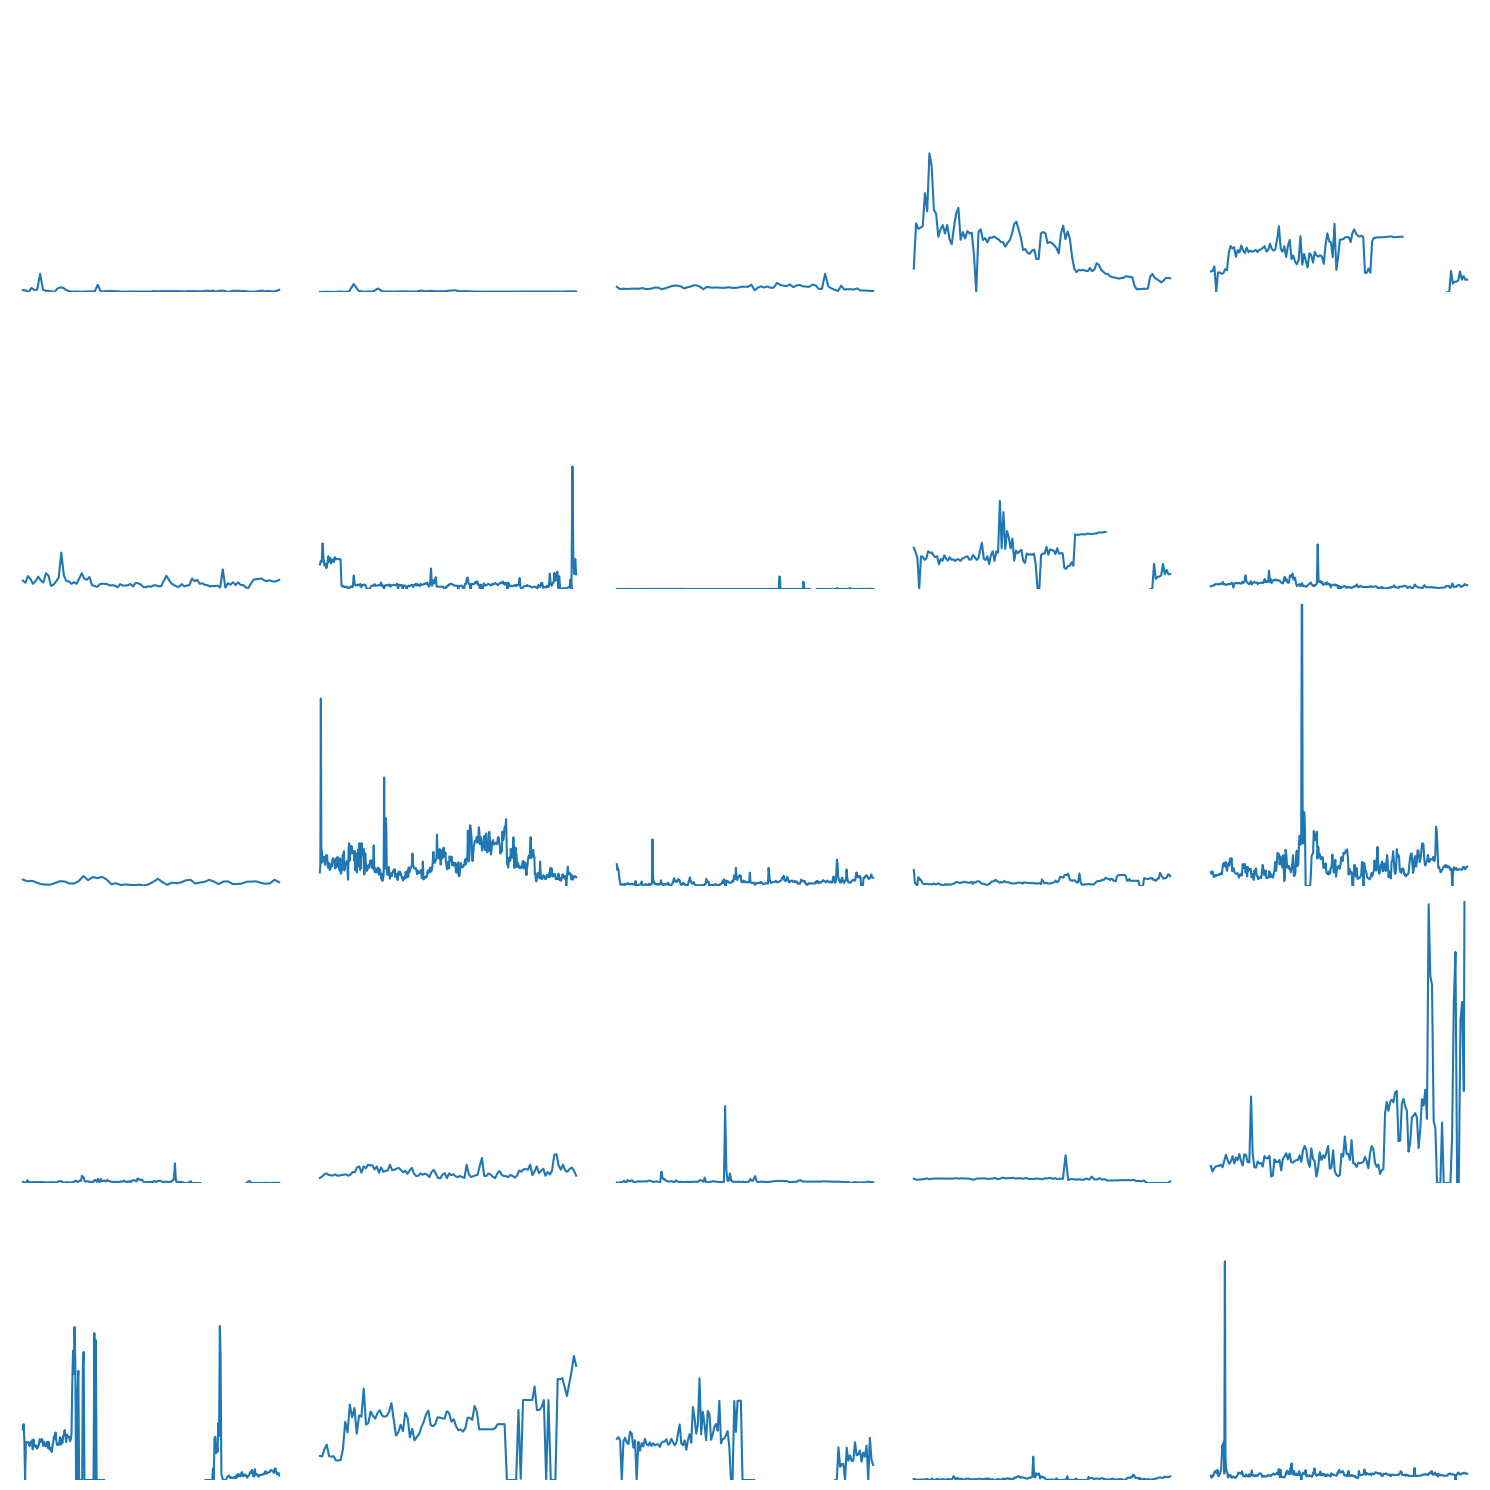

In [32]:

# Plot each row in a subplot
num_plots = len(pivot_df)
num_cols = 5
num_rows = 5

plt.figure(figsize=(15, 15))
y_min = pivot_df.min().min()
y_max = pivot_df.max().max()
for i, (well, row) in enumerate(pivot_df.iterrows(), 1):
    plt.subplot(num_rows, num_cols, i)
    plt.plot(row.values)
    #plt.title(well)
    #plt.xlabel('Date')
    #plt.ylabel('Value')
    plt.ylim(y_min, 500)
    plt.box(False)  # Remove bounding box
    plt.xticks([])   # Remove x-axis ticks
    plt.yticks([])   # Remove y-axis ticks


plt.tight_layout()
plt.show()

In [56]:
def find_common_limits(df):
    common_x_min = df.columns.min()
    common_x_max = df.columns.max()
    common_y_min = df.min().min()
    common_y_max = df.max().max()
    return common_x_min, common_x_max, common_y_min, common_y_max
find_common_limits(df)

UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.StrDType'>) -> None

<Figure size 100x100 with 0 Axes>

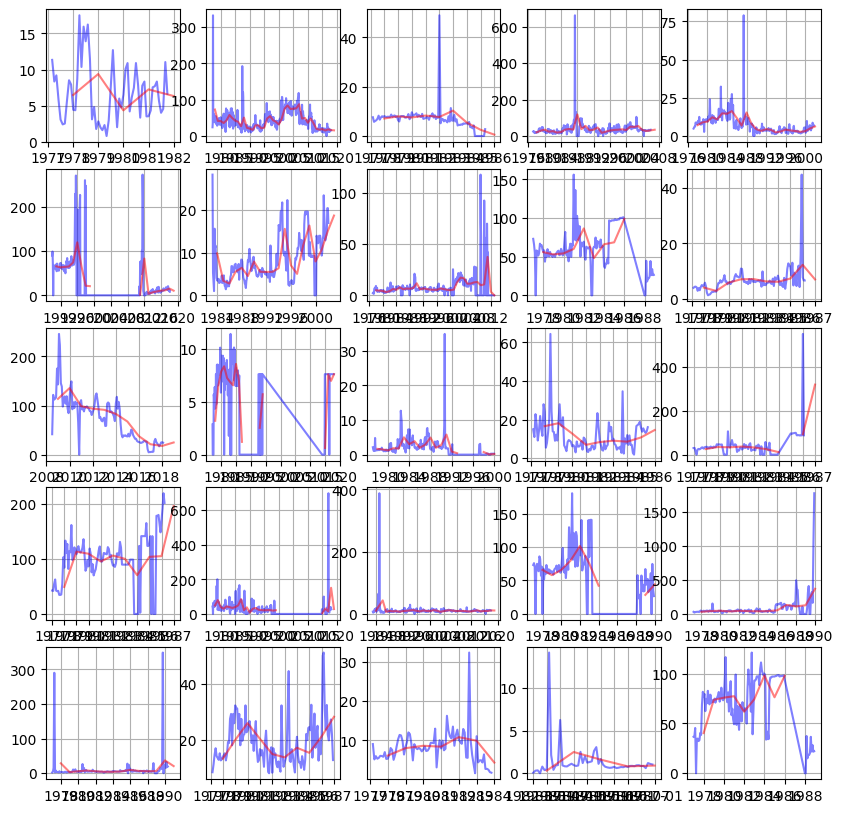

In [54]:
plt.figure(figsize=(1,1))
df_grouped = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
              .groupby('well')
)
plt.figure(figsize=(10,10))

for i,well_id in enumerate(wells):
    df_well = (df_grouped
    .get_group(well_id)
    .sort_values(['date'])
    #.filter(['date','value'])
    .set_index('date')
    )
    plt.subplot(5, 5, i + 1)
    plt.plot(df_well.index, df_well.value,color='blue',alpha=0.5)
    plt.grid(True)

    df_well_Y = df_well[["value"]].resample('YE').mean()
    plt.plot(df_well_Y.index, df_well_Y.value,color='red',alpha=.5)
plt.show()

In [30]:
# Describe statistics of the pivot table
pivot_stats = pivot_df.T.describe()
print(pivot_stats)

well    well_514   well_516    well_47    well_576    well_275     well_46  \
count  90.000000  54.000000  81.000000  116.000000  120.000000  101.000000   
mean    2.187299   1.319975   8.106330   73.136686   69.485323   11.538595   
std     3.717035   2.002028   4.052153   45.620896   27.585009    8.399430   
min     0.000000   0.000000   1.611765    0.000000    0.000000    1.871391   
25%     0.866036   0.711848   5.622159   32.154018   49.700832    6.087719   
50%     1.440972   0.863055   7.846939   79.262495   73.506252    9.181818   
75%     1.984375   1.110935   9.866667  103.851828   96.000000   15.120000   
max    32.312500  14.148148  32.333333  245.939655  121.064516   64.440000   

well     well_266    well_306    well_271    well_126  ...      well_2  \
count  273.000000  481.000000  120.000000  296.000000  ...  226.000000   
mean    11.742087    0.212698   61.545535    7.453924  ...    2.241170   
std     18.766452    1.553721   26.017299    6.498508  ...    2.926905   
m